# Neural Field

Download the Jupyter notebook : [NeuralField.ipynb](https://raw.githubusercontent.com/ANNarchy/ANNarchy.github.io/master/docs/example/NeuralField.ipynb)

The folder `examples/neural_field` contains a simple rate-coded model using [Neural Fields](http://www.scholarpedia.org/article/Neural_fields). It consists of two 2D populations `inp` and `focus`, with one-to-one connections between `inp` and `focus`, and Difference-of-Gaussians (DoG) lateral connections within `focus`.

## Model overview

Each population consists of N\*N neurons, with N=20. The `inp` population is solely used to represent inputs for `focus`. The firing rate of each neuron is defined by a simple equation:

$$r_i(t) = (\text{baseline}_i(t) + \eta(t))^+$$

where $r_i(t)$ is the instantaneous firing rate, $\text{baseline}_i(t)$ its baseline activity, $\eta(t)$ an additive
noise uniformly taken in $[-0.5, 0.5]$ and $()^+$ the positive function.

The `focus` population implements a discretized neural field, with neurons following the ODE:

$$\tau \frac{d r_i(t)}{dt} + r_i(t) = r^\text{input}_i(t) + \sum_{j=1}^{N} w_{j, i} \cdot r_j(t) + \eta(t)$$

where $r_i(t)$ is the neuron's firing rate, $\tau$ a time constant and $w_{j, i}$ the weight
value (synaptic efficiency) of the synapse between the neurons j and i.
$f()$ is a semi-linear function, ensuring the firing rate is bounded between 0 and 1.

Each neuron in `focus` takes inputs from the neuron of `inp` which has
the same position, leading to a `one_to_one` connection pattern.

The lateral connections within `focus` follow a difference-of-Gaussians (`dog`) connection pattern, with the connection weights $w_{i,j}$ depending on the normalized euclidian distance between the neurons in the N\*N population:

$$w_{j, i} = A^+ \cdot \exp(-\frac{1}{2}\frac{d(i, j)^2}{\sigma_+^2}) -  A^- \cdot \exp(-\frac{1}{2}\frac{d(i, j)^2}{\sigma_-^2})$$

If i and j have coordinates $(x_i, y_i)$ and $(x_j, y_j)$ in the N\*N
space, the distance between them is computed as:

$$d(i, j)^2 = (\frac{x_i - x_j}{N})^2 + (\frac{y_i - y_j}{N})^2$$

Inputs are given to the network by changing the baseline of `inp` neurons. This example clamps one or several gaussian profiles (called "bubbles") with an additive noise, moving along a circular path at a certain speed (launch the example to understand this sentence...).

## Importing ANNarchy

The beginning of the script solely consists of importing the ANNarchy library:

In [1]:
from ANNarchy import *
clear()

ANNarchy 4.7 (4.7.2) on darwin (posix).


If you want to run the simulation on your graphic card instead of CPU, simply uncomment the following line: 

In [2]:
#setup(paradigm="cuda")

The `setup()` method allows to configure ANNarchy to run in different modes, such as chosing the parallel framework (omp or cuda), setting the simulation step `dt`, the numerical method `method` or the `seed` of the random number generators.

## Defining the neurons

### Input neuron

In [3]:
InputNeuron = Neuron(   
    parameters="""
        baseline = 0.0
    """,
    equations="""
        r = pos(baseline + Uniform(-0.5, 0.5))
    """ 
)

Defining the input neuron is straightforward. `InputNeuron` is here an instance of `Neuron`, whose only parameter is
`baseline` (initialized to 0.0, but it does not matter here as it will be set externally). 

The firing rate of each neuron, `r`, is updated at every time step as the positive part (`pos()`) of the sum of the baseline and a random number taken from a uniform distribution between
-0.5 and 0.5.

### Neural Field neuron

In [4]:
NeuralFieldNeuron = Neuron(
    parameters=""" 
        tau = 10.0 : population
    """,
    equations="""
        tau * dr/dt + r = sum(exc) + sum(inh) + Uniform(-0.5, 0.5) : min=0.0, max=1.0
    """
)

The second neuron we need is a bit more complex, as it is governed by an
ODE and considers inputs from other neurons. It also has a non-linear
activation function, which is linear when the firing rate is
between 0.0 and 1.0, and constant otherwise.

`tau` is a population-wise parameter, whose value will be the same for
all neuron of the population. 

`r` is the firing rate of he neuron, whose dynamics are governed by a first-order linear ODE, integrating the sums of excitatory and inhibitory inputs with noise. 

As explained in the manual for rate-coded neurons, `sum(exc)` retrieves the weighted sum of pre-synaptic firing rates for the synapses having the connection type `exc`, here the one\_to\_one connections between `inp` and `focus`. `sum(inh)` does the same for `inh` type connections, here the lateral connections within `focus`.

The firing rate is restricted to the range [0, 1] by setting the `min` and `max` accordingly in the flags section (everything after the `:`). This means that after evaluating the ODE and getting a new value for `r`, its value will be clamped if it outside these values. One can define both `min` and `max`, only one, or none.  

## Creating the populations

The two populations have a geometry of (20, 20), therefore 400 neurons
each. They are created simply by instantiating the `Population` class:

In [5]:
N = 20
inp = Population(geometry = (N, N), neuron = InputNeuron, name='Input')
focus = Population(geometry = (N, N), neuron = NeuralFieldNeuron, name='Focus')

The populations can be assigned a unique name (here 'Input' and
'Focus') in order to be be able to retrieve them if the references
`inp` and `focus` are lost. They are given a 2D geometry and
associated to the corresponding `Neuron` instance.

## Creating the projections

The first projection is a one-to-one projection from Input to Focus with
the type 'exc'. This connection pattern pattern is possible because the
two populations have the same geometry. The weights are initialized to
1.0, and this value will not change with time (no learning), so it is
not necessary to define a synapse type:

In [6]:
ff = Projection(pre=inp, post=focus, target='exc')
ff.connect_one_to_one(weights=1.0, delays = 20.0)

The references to the pre- and post-synaptic population (or their
names), as well as the target type, are passed to the constructor of
`Projection`. The connector method `connect_one_to_one()` is immediately
applied to the Projection, defining how many synapses will be created.
The weights are initialized uniformly to 1.0.

The second projection is a difference of gaussians (DoG) for the lateral
connections within 'focus'. The connector method is already provided by
ANNarchy, so there is nothing more to do than to call it with the right
parameters:

In [7]:
lat = Projection(pre=focus, post=focus, target='inh')
lat.connect_dog(amp_pos=0.2, sigma_pos=0.1, amp_neg=0.1, sigma_neg=0.7)

## Compiling the network and simulating

Once the populations and projections are created, the network is ready to be generated, compiled and simulated. Compilation is simply done by calling `compile()`:

In [8]:
compile()

Compiling ...  OK 


This generates optimized C++ code from the neurons' definition and
network structure, compiles it with gcc/clang and instantiates all objects,
particularly the synapses. If some errors were made in the neuron
definition, they will be signaled at this point.

**Hint:** The call to `compile()` is mandatory in any script. After it is called, populations and projections can not be added anymore.

Once the compilation is successful, the network can be simulated by
calling `simulate()`:

```python
simulate(1000.0) # simulate for 1 second
```

As no input has been fed into the network, calling `simulate()` now
won't lead to anything interesting. The next step is to clamp inputs
into the input population's baseline.

## Setting inputs

### Pure Python approach

In this example, we consider as input a moving bubble of activity
rotating along a circle in the input space in 5 seconds. A naive way of
setting such inputs would be to access population attributes (namely
`inp.baseline`) in a tight loop in Python:


```python
angle = 0.0
x, y = np.meshgrid(np.linspace(0, 19, 20), np.linspace(0, 19, 20))

# Main loop
while True:
    # Update the angle
    angle += 1.0/5000.0
    # Compute the center of the bubble
    cx = 10.0 * ( 1.0 + 0.5 * np.cos(2.0 * np.pi * angle ) )
    cy = 10.0 * ( 1.0 + 0.5 * np.sin(2.0 * np.pi * angle ) )
    # Clamp the bubble into pop.baseline
    inp.baseline = (np.exp(-((x-cx)**2 + (y-cy)**2)/8.0))
    # Simulate for 1 ms
    step()  
```

`angle` represents the angle made by the bubble with respect to the
center of the input population. `x` and `y` are Numpy arrays
representing the X- and Y- coordinates of neurons in the input
population. At each iteration of the simulation (i.e. every millisecond
of simulation, the bubble is slightly rotated (`angle` is incremented)
so as to make a complete revolution in 5 seconds (5000 steps). `cx` and
`cy` represent the coordinates of the center of the bubble in neural
coordinates according to the new value of the angle.

A Gaussian profile (in the form of a Numpy array) is then clamped into
the baseline of `inp` using the distance between each neuron of the
population (`x` and `y`) and the center of the bubble. Last, a single
simulation step is performed using `step()`, before the whole process
starts again until the user quits. `step()` is equivalent to
`simulate(1)`, although a little bit faster as it does not check anything.

Although this approach works, you would observe that it is very slow:
the computation of the bubble and its feeding into `InputPop` takes much
more time than the call to `step()`. The interest of using a parallel
simulator disappears. This is due to the fact that Python is knowingly
bad at performing tight loops because of its interpreted nature. If the
`while` loop were compiled from C code, the computation would be much
more efficient. This is what Cython brings you.

### Cython approach

**Generalities on Cython**

The Cython approach requires to write Cython-specific code in a `.pyx`
file, generate the corresponding C code with Python access methods,
compile it and later import it into your Python code.

Happily, the Cython syntax is very close to Python. In the most basic approach, it is simply Python code with a couple of type declarations. Instead of:

```cython
bar = 1
foo = np.ones((10, 10))
```

you would write in Cython:

```cython
cdef int bar = 1
cdef np.ndarray foo = np.ones((10, 10))
```

By specifing the type of a variable (which can not be changed later
contrary to Python), you help Cython generate optimized C code, what can
lead in some cases to speedups up to 100x. The rest of the syntax
(indentation, for loops, if...) is the same as in Python. 

You can als import any Python module in your Cython code. Some modules (importantly
Numpy) even provide a Cython interface where the equivalent Cython code
can be directly imported (so it becomes very fast to use).

The whole compilation procedure is very easy. One particularly simple approach is to use the `pyximport` module shipped with Cython. Let us suppose you wrote a `dummy()` method in a Cython file named `TestModule.pyx`. All you need to use this method in your python code is to write:

```python
import pyximport; pyximport.install()
from TestModule import dummy
dummy()
```

`pyximport` takes care of the compilation process (but emits quite a lot
of warnings that can be ignored), and allows to import `TestModule` as if it were a regular
Python module. Please refer to the [Cython
documentation](http://docs.cython.org) to know more.


**Moving bubbles in Cython**

The file `BubbleWorld.pyx` defines a `World` class able to rotate the bubble
for a specified duration.

```cython
import numpy as np
cimport numpy as np
```

At the beginning of the file, numpy is imported once as a normal Python
module with `import`, and once as a Cython module with `cimport`. This
allows our Cython module to access directly the internal representations
of Numpy without going through the Python interpreter. 

We can then define a `World` class taking as parameters:

-   the population which will be used as input (here `Input`),
-   several arguments such as `radius`, `sigma` and `period` which allow
    to parameterize the behavior of the rotating bubble,
-   `func` which is the Python method that will be called at each time step, i.e.e the `step()` method of ANNarchy.

```cython
cdef class World:
    " Environment class allowing to clamp a rotating bubble into the baseline of a population."
    
    cdef pop # Input population
    cdef func # Function to call

    cdef float angle # Current angle
    cdef float radius # Radius of the circle 
    cdef float sigma # Width of the bubble
    cdef float period # Number of steps needed to make one revolution

    cdef np.ndarray xx, yy # indices
    cdef float cx, cy, midw, midh
    cdef np.ndarray data 
    
    def __cinit__(self, population, radius, sigma, period, func):
        " Constructor"
        self.pop = population
        self.func=func
        self.angle = 0.0
        self.radius = radius
        self.sigma = sigma
        self.period = period
        cdef np.ndarray x = np.linspace(0, self.pop.geometry[0]-1, self.pop.geometry[0])
        cdef np.ndarray y = np.linspace(0, self.pop.geometry[1]-1, self.pop.geometry[1])
        self.xx, self.yy = np.meshgrid(x, y)
        self.midw = self.pop.geometry[0]/2
        self.midh = self.pop.geometry[1]/2
    
    def rotate(self, int duration):
        " Rotates the bubble for the given duration"
        cdef int t
        for t in xrange(duration):
            # Update the angle
            self.angle += 1.0/self.period
            # Compute the center of the bubble
            self.cx = self.midw * ( 1.0 + self.radius * np.cos(2.0 * np.pi * self.angle ) )
            self.cy = self.midh * ( 1.0 + self.radius * np.sin(2.0 * np.pi * self.angle ) )
            # Create the bubble
            self.data = (np.exp(-((self.xx-self.cx)**2 + (self.yy-self.cy)**2)/2.0/self.sigma**2))
            # Clamp the bubble into pop.baseline
            self.pop.baseline = self.data
            # Simulate for 1 step
            self.func()  
```

Although this tutorial won't go into much detail, you can note the
following:

-   The data given to or initialized in the constructor are previously
    declared (with their type) as attributes of the class. This way,
    Cython knows at the compilation time which operations are possible
    on them, which amount of memory to allocate and so on, resulting in
    a more efficient implementation.
-   The input population (`self.pop`) can be accessed as a normal
    Python object. In particular, self.pop.geometry is used in the
    constructor to initialize the meshgrid.
-   The method `rotate()` performs the simulation for the given duration
    (in steps, not milliseconds). Its content is relatively similar to
    the Python version.


**Running the simulation**

Once the environment has been defined, the simulation can be executed.
The following code, to be placed after the network definition, performs
a simulation of the network, taking inputs from `BubbleWorld.pyx`,
during 2 seconds:

In [ ]:
# Create the environment
import pyximport; pyximport.install(setup_args={'include_dirs': np.get_include()})
from BubbleWorld import World
world = World(population=inp, radius=0.5, sigma=2.0, period=5000.0, func=step)

# Simulate for 2 seconds with inputs
world.rotate(2000)

### Visualizing the network

The preceding code performs correctly the intended simulation, but
nothing is visualized. The user has all freedom to visualize his network
the way he prefers (for example through animated Matplotlib figures):

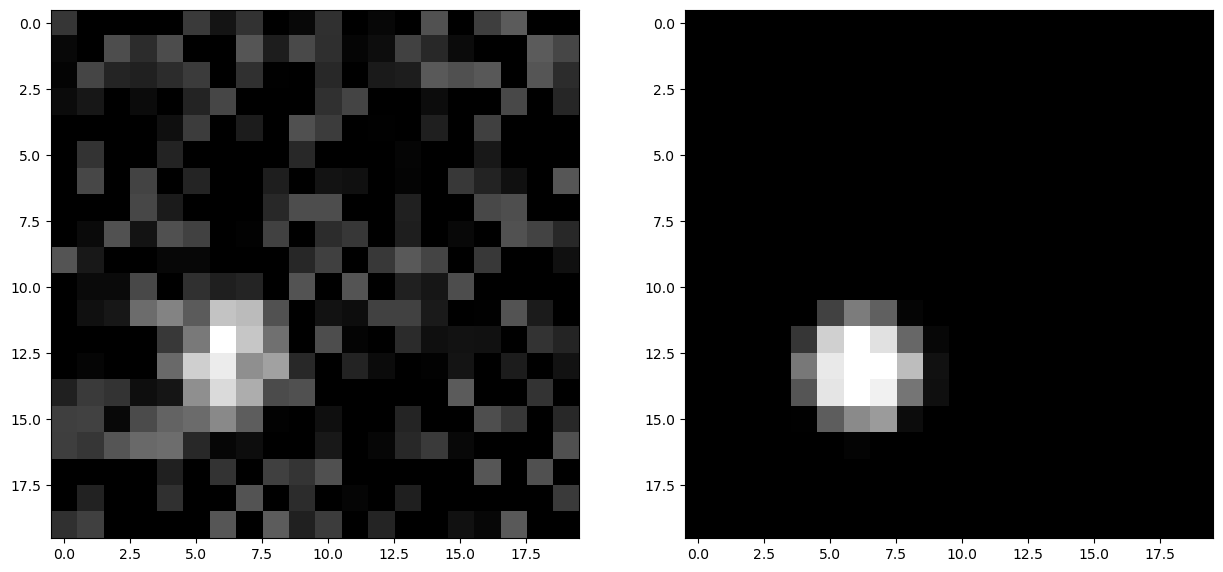

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))
plt.subplot(121)
plt.imshow(inp.r, interpolation='nearest', cmap=plt.cm.gray)
plt.subplot(122)
plt.imshow(focus.r, interpolation='nearest', cmap=plt.cm.gray)
plt.show()

However, Matplotlib animations are rather slow, and visualizing the network at each time step would take more time than running the simulation. The provided example takes advantage of the PyQtGraph library (www.pyqtgraph.org) to visualize efficiently activity in the network using OpenGL.

The following class and method is defined in `Viz.py`:

```python
# Visualizer using PyQtGraph
try:
    from pyqtgraph.Qt import QtGui, QtCore
    import pyqtgraph as pg
except:
    print('PyQtGraph is not installed on your system, can not visualize the network.')
    exit(0)
try:
    import pyqtgraph.opengl as gl
except:
    print('OpenGL is not installed on your system, can not visualize the network.')
    exit(0)

import numpy as np

class GLViewer(object):
    " Class to visualize the network activity using PyQtGraph and openGL."
    def __init__(self, populations, func, update_rate): 
        # Parameters   
        self.populations = populations
        self.func = func    
        self.update_rate = update_rate
        # Window
        self.win = gl.GLViewWidget()
        self.win.show()
        self.win.setCameraPosition(distance=40)
        # Prepare the plots
        self.plots = []
        shift = 0
        for pop in self.populations: 
            p = gl.GLSurfacePlotItem(
                x = np.linspace(0, pop.geometry[0]-1, pop.geometry[0]), 
                y = np.linspace(0, pop.geometry[1]-1, pop.geometry[1]), 
                shader='heightColor', 
                computeNormals=False, 
                smooth=False
            )
            p.translate(shift, -10, -1)
            self.win.addItem(p)
            self.plots.append(p)
            shift -= 25

    def scale(self, data):
        " Colors are shown in the range [-1, 1] per default."
        return 1.8 * data -0.9

    def update(self):
        "Callback"
        # Simulate for 200ms
        self.func(self.update_rate)     
        # Refresh the GUI
        for i in range(len(self.populations)):
            self.plots[i].setData(z=self.scale(self.populations[i].r)) 
        # Listen to mouse/keyboard events
        QtGui.QApplication.processEvents()

    def run(self):
        "Inifinite loop"
        timer = QtCore.QTimer()
        timer.timeout.connect(self.update)
        timer.start(0)  
        QtGui.QApplication.instance().exec_() 


def loop_bubbles(populations, func, update_rate):
    "Launches the GL GUI and rotates the bubble infinitely."
    # Create the GUI using PyQtGraph
    app = QtGui.QApplication([])
    viewer = GLViewer(populations, func, update_rate)
    # Start the simulation forever          
    viewer.run()
```

We leave out again the details about this class (please look at the
examples and tutorials on the PyQtGraph website to understand it). It
allows to open a PyQtGraph window and display the firing rate of both
`Input` and `Focus` populations using OpenGL. The `run()` method is an endless loop calling regularly the
`update()` method.

The `update()` method calls first `World.rotate(200)` and waits for its
completion before reactualizing the display. The reason is that
refreshing the display can only be done sequentially with the
simulation, and calling it too often would impair the simulation time.

Once this class has been defined, the simulation can be run endlessly by importing the `Viz` module:

In [ ]:
# Launch the GUI and run the simulation
from Viz import loop_bubbles
loop_bubbles(populations = [inp, focus], func=world.rotate, update_rate=200)